## Идея

Возьмем заголовки новостей с Фонтанки.ру за последний месяц:

Каждая новость имеет систему рейтинга - пять различных эмоций.

Например, новость с заголовком **"На Колыме могут ввести курортный сбор"** имеет следующий набор реакций



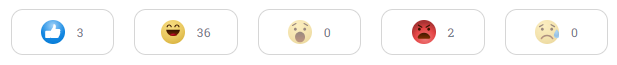

Можно однозначно сказать, что новость относится к категории "Веселая", однако не всегда можно выделить одну преобладающую реакцию или вовсе нет.

К примеру, новость с заголовком **"16-летний Адам Кадыров стал куратором еще одного батальона"** имеет следующий набор реакций:

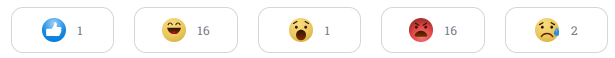

Нельзя однозначно сказать, что эта новость "Веселая" либо "Негативная", она явно относится к обоим категориям

### Парсер
Узнаем, что у Фонтанки ру есть апи, позволяющее получить все новости за конкретную дату

https://newsapi.fontanka.ru/v1/public/fontanka/services/archive/?regionId={}&page={}&pagesize={}&date={}&rubricId=all

Все дальнейшее - дело техники

In [ ]:
import json
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch


In [ ]:
from bs4 import BeautifulSoup as BS


class Parser:
  def __init__(self):
    self.REGION = 478 # ???
    self.PAGE_SIZE = 300
    self.session = requests.Session()

  def getEmotion(self, url):
    post = self.session.get(url).text
    result = []
    for emotion in ['ЛАЙК', 'СМЕХ', 'УДИВЛЕНИЕ', 'ГНЕВ', 'ПЕЧАЛЬ']:
      right = post[post.index('">' + emotion + '</span>') + len('">' + emotion + '</span>') : ]
      left = right[:right.index('</span>')]
      value = int(left[left.index('>') + 1:])
      result.append(value)
    soup = BS(post)
    text = soup.find('section', {'itemprop':'articleBody'}).text
    if sum(result) == 0:
      return [0] * 5, 0, text
    return [i / sum(result) for i in result], sum(result),  text


  def parsePosts(self, data):
    result = []
    for i in data:
      try:
        emotion, count, text = self.getEmotion(i['urls']['urlCanonical'])
        result.append({
            'header': i['header'],
            'emotion': emotion,
            'emotionCount': count,
            'text': text
        })
      except Exception:
        print('no emotion: ' + i['urls']['urlCanonical'])
    return result

  def getPage(self, page: int, date: str, size: int):
    response = self.session.get('https://newsapi.fontanka.ru/v1/public/fontanka/services/archive/?regionId=' + str(self.REGION) + '&page=' + str(page) + '&pagesize=' + str(size) + '&date=' + date + '&rubricId=all')
    data = response.json()
    if data['statusCode'] != 200:
      print(data)
      return []
    return self.parsePosts(data['data'])

  def getAllPosts(self, date: str):
    page = 1
    answer = []
    while True:
      result = self.getPage(page, date, self.PAGE_SIZE)
      if len(result) == 0:
        break
      answer += result
      page += 1
    return answer

parser = Parser()

In [ ]:
parser.getPage(4, "12.12.2023", 1)

[{'header': 'Премьера режиссерской версии «Александры» Сокурова пройдет в «Англетере»',
  'emotion': [0.7, 0.0, 0.1, 0.2, 0.0],
  'emotionCount': 20,
  'text': 'Премьера фильма Александра Сокурова «Александра. Авторская редакция 2023 года» состоится 18 декабря в петербургском кинотеатре Angleterre Cinema Lounge, сообщили 12 декабря в телеграм-канале «Остров Сокурова».Премьеру представит сам мастер. Сеанс с возрастным ограничением 16+ начнется в 20:00.Ранее показ ленты с Галиной Вишневской к годовщине ее смерти планировался в кинотеатре «Аврора» на 12 декабря при участии не только Сокурова, но и Ольги Ростропович. Однако он был перенесен: в этот вечер в кинотеатре прошли сеансы ко Дню Конституции — зрителям показывали три фильма Сергея Дебижева: «Хлеб, "Север" и кобальт» о тех, кто выжил в блокаду, «Гимн великому городу» и «Крым небесный».\n\n\n\n\n\n'}]

Видно, что не для всех новостей есть реакции. Это не проблема парсера, фонтанка отключает реакции для:

1) Рекламных записей (?erid=2SDnjdt2SRv)

2) Статей про здоровье с другого ресурса (doctorpiter.ru)

3) Некоторых конкретных новостей, например, с военной тематикой/боевыми действиями

4) Некоторые статьи являются рекламой без явного erid :)

Получим данные о постах за **последниe 30 дней**:

In [ ]:

count = 60
start = datetime.datetime.strptime('15.12.2023', '%d.%m.%Y')
result = [start]
for i in range(count - 1):
  result.append(result[-1] - datetime.timedelta(days=1))
result = [i.date() for i in result]
dates = [str(i.day) + "." + str(i.month) + "." + str(i.year) for i in result]
print(dates)

['15.12.2023', '14.12.2023', '13.12.2023', '12.12.2023', '11.12.2023', '10.12.2023', '9.12.2023', '8.12.2023', '7.12.2023', '6.12.2023', '5.12.2023', '4.12.2023', '3.12.2023', '2.12.2023', '1.12.2023', '30.11.2023', '29.11.2023', '28.11.2023', '27.11.2023', '26.11.2023', '25.11.2023', '24.11.2023', '23.11.2023', '22.11.2023', '21.11.2023', '20.11.2023', '19.11.2023', '18.11.2023', '17.11.2023', '16.11.2023', '15.11.2023', '14.11.2023', '13.11.2023', '12.11.2023', '11.11.2023', '10.11.2023', '9.11.2023', '8.11.2023', '7.11.2023', '6.11.2023', '5.11.2023', '4.11.2023', '3.11.2023', '2.11.2023', '1.11.2023', '31.10.2023', '30.10.2023', '29.10.2023', '28.10.2023', '27.10.2023', '26.10.2023', '25.10.2023', '24.10.2023', '23.10.2023', '22.10.2023', '21.10.2023', '20.10.2023', '19.10.2023', '18.10.2023', '17.10.2023']


In [ ]:
for date in dates:
  posts = parser.getAllPosts(date)
  with open(date + '.json', 'w') as file:
    json.dump(posts, file)

no emotion: https://doctorpiter.ru/obraz-zhizni/son-pridi-8-privychek-kotorye-tolko-usilyat-bessonnicu-i-sdelayut-ee-khronicheskoi-id955162/
no emotion: https://doctorpiter.ru/obraz-zhizni/est-v-lyubom-magazine-deshevykh-tovarov-eto-sredstvo-pomozhet-izbavitsya-ot-pleseni-v-vannoi-id976132/
no emotion: https://doctorpiter.ru/obraz-zhizni/chto-dobavit-v-chai-chtoby-on-stal-eshe-poleznee-5-idei-dlya-zimnego-vechera-id973003/
no emotion: https://www.fontanka.ru/2023/12/15/73025546/
no emotion: https://www.fontanka.ru/2023/12/15/73024127/?erid=2SDnjc39x16
no emotion: https://doctorpiter.ru/obraz-zhizni/7-priznakov-po-kotorym-vrach-geriatr-opredelyaet-chto-vy-stareete-nepravilno-id977799/
no emotion: https://www.fontanka.ru/2023/12/14/73015265/?erid=LatgC5rLr
no emotion: https://www.fontanka.ru/2023/12/15/73022450/?erid=2SDnjeBhutc
no emotion: https://doctorpiter.ru/zdorove/uchenye-vyyasnili-chto-vrednee-vypivat-chasto-i-po-chut-chut-ili-redko-no-metko-id976271/
no emotion: https://www.font

Объеденим данные:

In [ ]:
result = []
for date in dates:
  with open(date + '.json', 'r') as file:
    data = json.load(file)
    result += data
json.dump(result, open('dataset3.json', 'w'))
print(result[10:20])

NameError: ignored

In [405]:
result = json.load(open('dataset3.json', 'r'))

Некоторые заголовки содержат html-теги, уберем их

In [406]:
from bs4 import BeautifulSoup

for i in result:
  i['header'] = BeautifulSoup(i['header'], "lxml").text
  i['text'] = BeautifulSoup(i['text'], "lxml").text
print(result[10:20])


<ipython-input-406-711390ed6f4f>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  i['header'] = BeautifulSoup(i['header'], "lxml").text


[{'header': 'Правительство повысило до 30% первый взнос по льготной ипотеке', 'emotion': [0.19402985074626866, 0.34328358208955223, 0.029850746268656716, 0.373134328358209, 0.05970149253731343], 'emotionCount': 67, 'text': 'Размер первоначального взноса по льготной ипотеке под 8% годовых повышен с 20 до 30%. Решение принято правительством России 15 декабря.«Новым постановлением до 30% повышен взнос по льготной ипотеке, которая выдается по ставке 8% годовых на покупку жилья в новостройках, строительство частного дома или приобретение земельного участка для его строительства. Эта мера направлена на повышение качества кредитов», — рассказали в Минфине РФ.Кроме того, максимальный размер льготного ипотечного кредита для всех регионов, включая столичные, теперь составляет 6 млн рублей. Ранее лимит по льготной ипотеке для Москвы, Петербурга, Подмосковья и Ленобласти составлял 12 млн рублей.\n\n\nНовые требования к первоначальному взносу по льготной ипотеке в России начнут действовать с 23 дек

Преобразуем данные в Pandas.Dataframe

In [407]:
converted = []
for i in result:
  value = {
      'header': i["header"],
      'like': i['emotion'][0],
      'funny': i['emotion'][1],
      'wonder': i['emotion'][2],
      'anger': i['emotion'][3],
      'sadness': i['emotion'][4],
      'emotionCount': i['emotionCount'],
      'text': i['text'],
      'joined': i['header'] + " " + i['text']
  }
  converted.append(value)

df = pd.DataFrame(converted, columns = ['header', 'like', 'funny', 'wonder', 'anger', 'sadness', 'emotionCount', 'text', 'joined'])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   header        6316 non-null   object 
 1   like          6316 non-null   float64
 2   funny         6316 non-null   float64
 3   wonder        6316 non-null   float64
 4   anger         6316 non-null   float64
 5   sadness       6316 non-null   float64
 6   emotionCount  6316 non-null   int64  
 7   text          6316 non-null   object 
 8   joined        6316 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 444.2+ KB
None
                                              header      like     funny  \
0  ЦАХАЛ: израильские солдаты по ошибке застрелил...  0.050000  0.212500   
1  Певица Елена Ваенга потеряла сознание в москов...  0.074627  0.701493   
2  Ловим сигналы ЦБ. Что будет с ключевой ставкой...  0.120000  0.680000   
3  Финны не впустили последних: людям пришлось р

In [408]:
print(len(df[df.emotionCount >= 15]))

4167


Будем рассматривать посты, у которых есть **хотя бы 10 реакций**, таких около 5 тысяч:

In [409]:
df = df[df.emotionCount >= 15]

<Axes: >

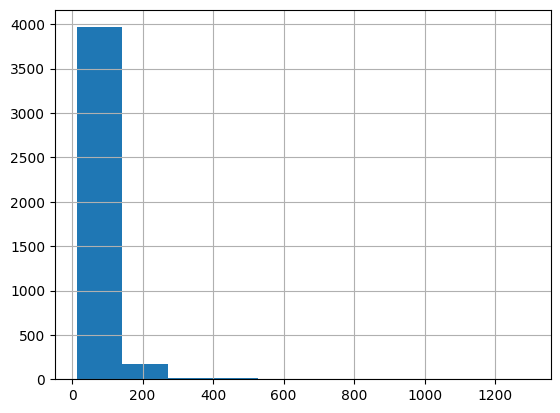

In [410]:
df['emotionCount'].hist()

<Axes: >

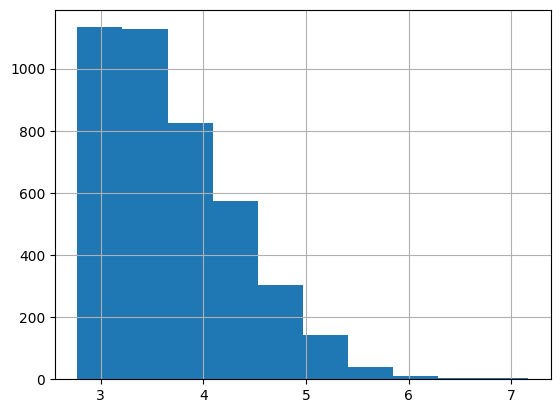

In [411]:
df['emotionCountLog'] = np.log1p(df['emotionCount'])
df['emotionCountLog'].hist()

Сами реакции - вектора. Построим UMAP:

In [ ]:
!pip install umap
!pip install umap-learn


  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=8b31a070c543122dace7faa586c9e1f86fb5b25b0da374df684120229c969568
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=a382a6ba7ba268c1bc90180893480a0182054e17938fef1ca7a4a80d0c141655
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import umap
points = umap.UMAP(random_state=42).fit_transform(df[['like', 'funny', 'wonder', 'anger', 'sadness']])
print(points)

ValueError: ignored

like


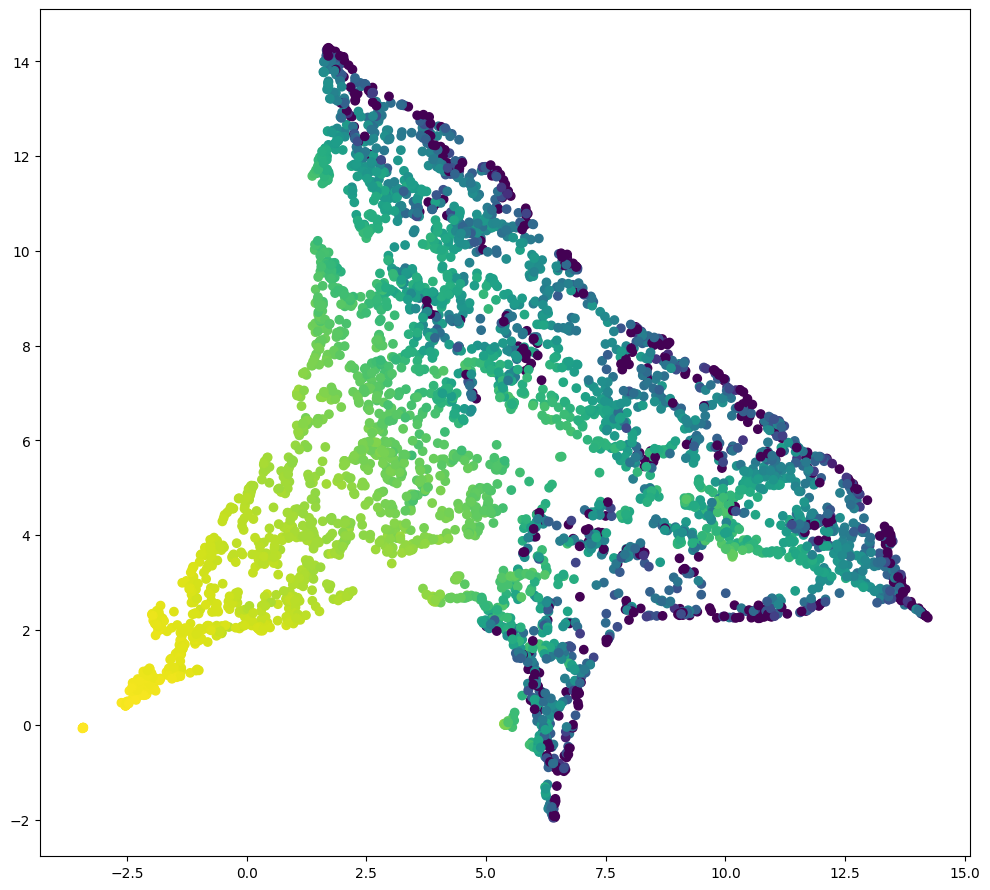

funny


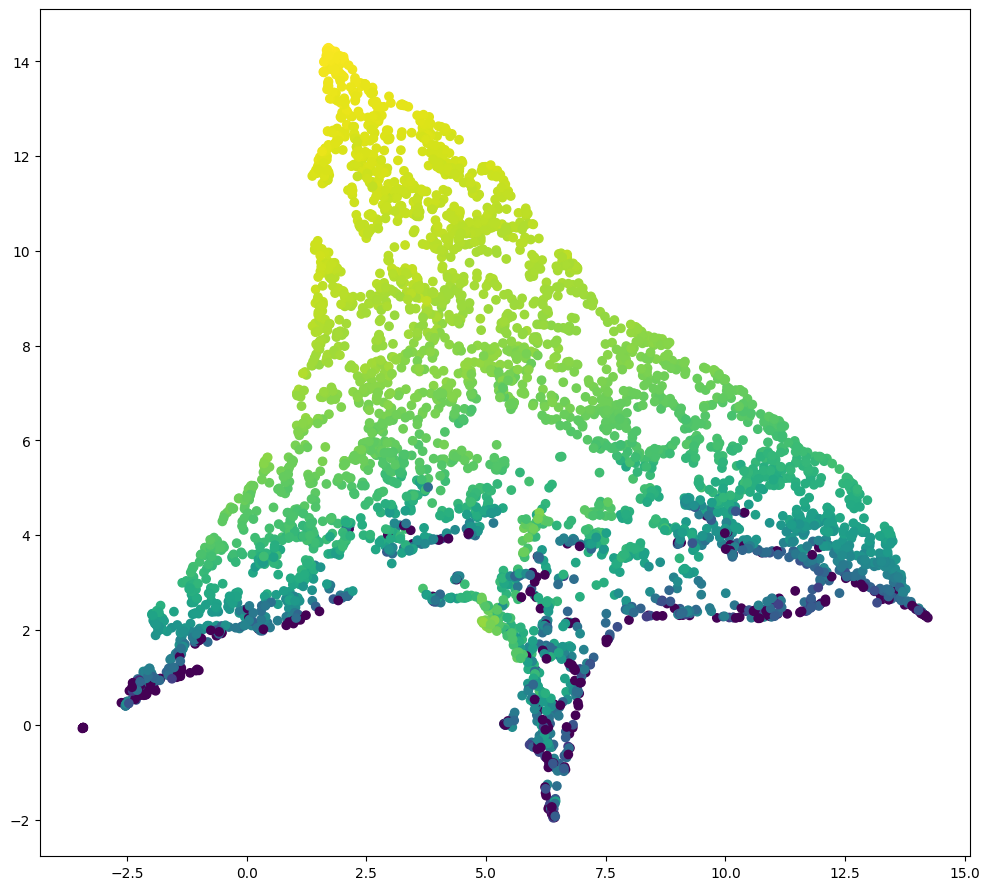

wonder


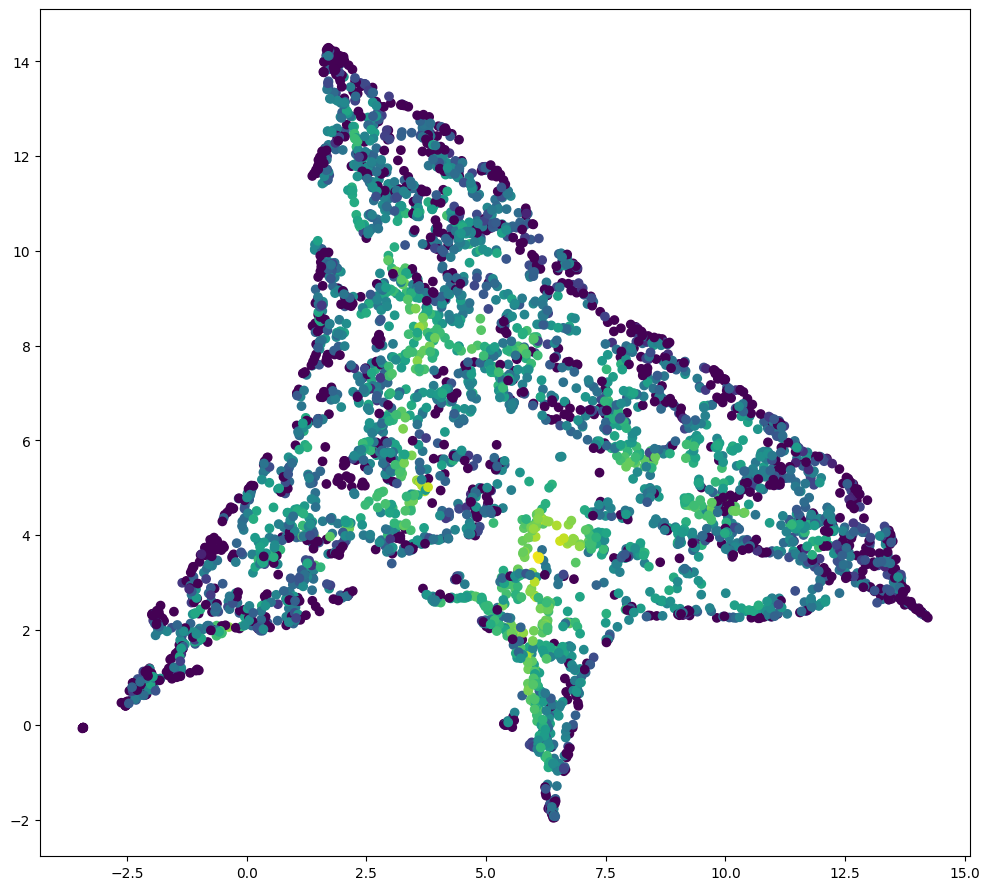

anger


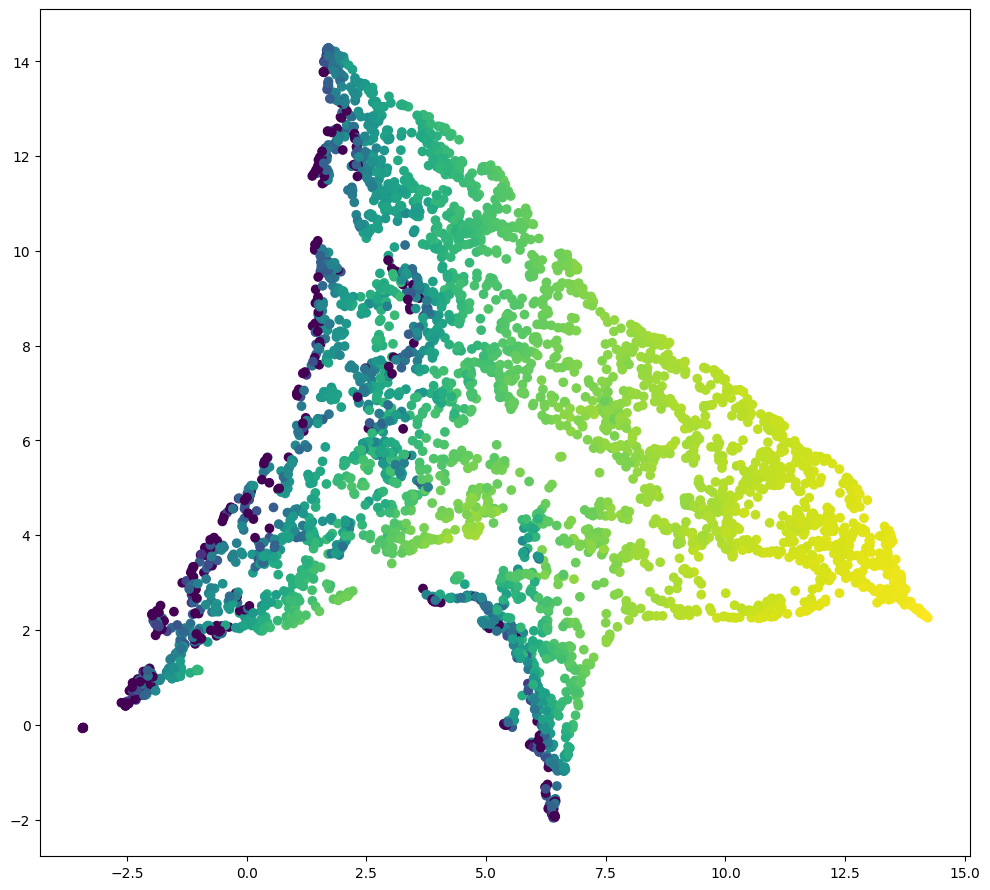

sadness


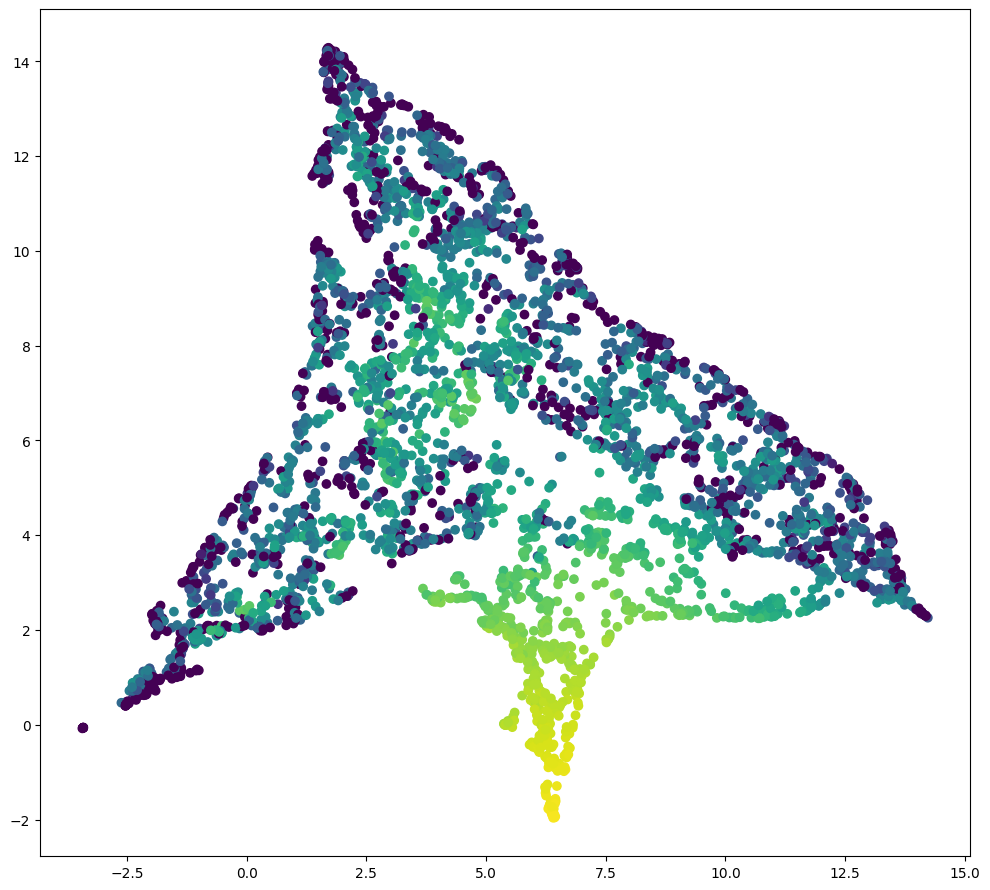

In [ ]:
color = np.log1p(df.like * 100)
print('like')
plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color)
plt.show()
print('funny')
color = np.log1p(df.funny * 100)

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color)
plt.show()
print('wonder')
color = np.log1p(df.wonder * 100)

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color)
plt.show()
print('anger')
color = np.log1p(df.anger * 100)

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color)
plt.show()
print('sadness')
color = np.log1p(df.sadness * 100)

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color)
plt.show()

Тут мы видим, что как категория "удивление" почти отсутствует, так как равномерно распределена по всем постам

Более того, отметка "весело", как ни странно, присутствует так или иначе в большинстве постов (кроме постов с очень большим преобладанием "лайк", "гнев" и "печаль").

Разобьем заголовки на слова

In [412]:
from typing import List
from collections import Counter
from itertools import chain

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    return text

texts = [preprocess_text(text) for text in df.joined.tolist()]
vocab = build_vocab(texts)
print(len(vocab))


116750


In [413]:

vocab.most_common(30)

[('в', 47738),
 ('и', 29652),
 ('на', 23254),
 ('с', 12937),
 ('не', 12735),
 ('что', 12393),
 ('по', 11086),
 ('из', 5971),
 ('а', 5365),
 ('о', 5341),
 ('как', 5033),
 ('за', 5001),
 ('это', 4792),
 ('к', 4642),
 ('но', 4249),
 ('он', 4118),
 ('у', 3912),
 ('для', 3743),
 ('его', 3629),
 ('от', 3597),
 ('до', 3243),
 ('года', 2946),
 ('этом', 2607),
 ('россии', 2566),
 ('ноября', 2545),
 ('об', 2282),
 ('уже', 2242),
 ('после', 2189),
 ('все', 2184),
 ('я', 2037)]

Удалим стоп-слова

In [414]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

rus_stopwords = stopwords.words('russian')

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))

    is_stopword = lambda word: word not in rus_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


texts = [preprocess_text(text) for text in df.joined.tolist()]
vocab = build_vocab(texts)
print(len(vocab))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


116600


Проведем стемминг

In [415]:
from tqdm import tqdm
from nltk.stem import PorterStemmer
import nltk

stemmer = PorterStemmer()

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))

    is_stopword = lambda word: word not in rus_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))

    text = ' '.join(list(map(stemmer.stem, text.split())))
    return text


texts = []
for text in tqdm(df.joined.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)

100%|██████████| 4167/4167 [00:36<00:00, 115.41it/s]


In [416]:

print(len(vocab))
vocab.most_common()[:30]


116572


[('это', 4792),
 ('года', 2946),
 ('россии', 2566),
 ('ноября', 2545),
 ('фонтанкаруфото', 1983),
 ('рублей', 1956),
 ('также', 1897),
 ('году', 1754),
 ('которые', 1742),
 ('октября', 1723),
 ('рф', 1646),
 ('декабря', 1553),
 ('петербурге', 1522),
 ('петербурга', 1483),
 ('который', 1375),
 ('лет', 1270),
 ('время', 1259),
 ('сообщает', 1105),
 ('тысяч', 1078),
 ('человек', 1046),
 ('словам', 1012),
 ('заявил', 1010),
 ('очень', 1006),
 ('фото', 1002),
 ('данным', 982),
 ('изза', 976),
 ('фонтанки', 960),
 ('фонтанке', 943),
 ('михаил', 918),
 ('сергей', 908)]

Удалим стоп-слова корпуса


In [417]:
for word, freq in vocab.most_common(10):
    if word in vocab:  # чтобы код не сломался при повторном исполнении
        vocab.pop(word)


In [418]:
print(len(vocab))
vocab.most_common()[:10]

116562


[('рф', 1646),
 ('декабря', 1553),
 ('петербурге', 1522),
 ('петербурга', 1483),
 ('который', 1375),
 ('лет', 1270),
 ('время', 1259),
 ('сообщает', 1105),
 ('тысяч', 1078),
 ('человек', 1046)]

Закодируем посты

In [419]:
converter = {word: ix for ix, word in enumerate(vocab)}

Предскажем грустность новости

Напишем ***мОдЕлЬ***

<Axes: >

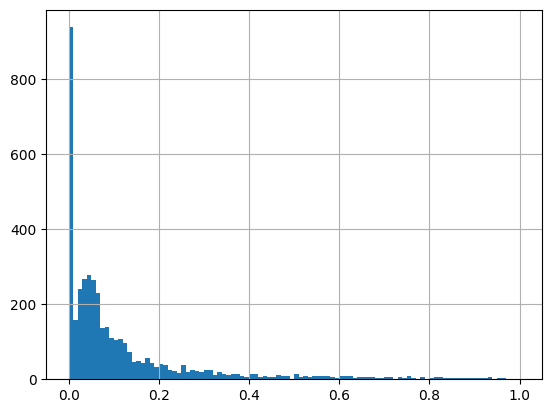

In [421]:
df['sadness'].hist(bins=100)

In [450]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error


def train(model, x, y, epochs) -> nn.Module:
    # Определение функции потерь и оптимизатора
    # pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.manual_seed(42 )
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters())

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

    train_history = []
    test_history = []

    # Итерации прохода по датасету - эпохи
    # Деление датасета внутри эпохи - батчирование
    for epoch in range(epochs):
        ## train

        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямой проход
        if (torch.any(torch.isnan(train_x)))|(torch.any(torch.isnan(train_y))):
          print("NaN values found in", epoch, i)
          break
        outputs = model(train_x).squeeze()
        loss = criterion(outputs, train_y)
        # Обратное распространение ошибки
        loss.backward()
        # Обновление весов
        optimizer.step()

        train_history.append(loss.item())
        #if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


        ## test
        with torch.no_grad():
            outputs = model(test_x).squeeze()
            loss = criterion(outputs, test_y)
            test_history.append(loss.item())
    # calc metrics
    probs = model(x).max(dim=1).values.detach().numpy()
    print(probs)

    #score = mean_squared_error(y, probs)
    #print(f'mse {score:.3f} (на {abs(score - 0.5):.3f} лучше рандома)')
    model.eval()
    #for i in range(len(train_x)):
    #  print(model(torch.atleast_2d(train_x[i])), train_y[i])
    plt.plot(train_history)
    plt.plot(test_history)
    plt.grid(True)
    plt.title('Сходимость')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка')
    plt.legend(['train', 'test'])
    plt.show()

    return model

In [446]:
class Model(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(Model, self).__init__()
        embedding_size = 5

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 10, 1, batch_first=True)
        #self.sigmoid = nn.Sigmoid()
        self.model = nn.Sequential(
            #nn.ReLU(),
            nn.BatchNorm1d(10),
            #nn.Linear(25, 25),
            #nn.Sigmoid(),
            #nn.Linear(300, 50),
            #nn.BatchNorm1d(5),
            #nn.Linear(5, 5),
            #nn.BatchNorm1d(20),
            nn.Dropout(p=0.2),
            #nn.Linear(50, 50),
            #nn.RReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_output, (last_hidden_state, last_cell_state) = self.lstm(embeds)
        res = self.model(lstm_output[:, -1])
        return res


torch.Size([4167])
Epoch [1/15], Loss: 0.7930
Epoch [2/15], Loss: 0.7049
Epoch [3/15], Loss: 0.6405
Epoch [4/15], Loss: 0.5940
Epoch [5/15], Loss: 0.5494
Epoch [6/15], Loss: 0.5074
Epoch [7/15], Loss: 0.4724
Epoch [8/15], Loss: 0.4337
Epoch [9/15], Loss: 0.4085
Epoch [10/15], Loss: 0.3811
Epoch [11/15], Loss: 0.3668
Epoch [12/15], Loss: 0.3610
Epoch [13/15], Loss: 0.3499
Epoch [14/15], Loss: 0.3279
Epoch [15/15], Loss: 0.3153
[0.10219148 0.05829045 0.10979127 ... 0.6355785  0.11740527 0.3594581 ]


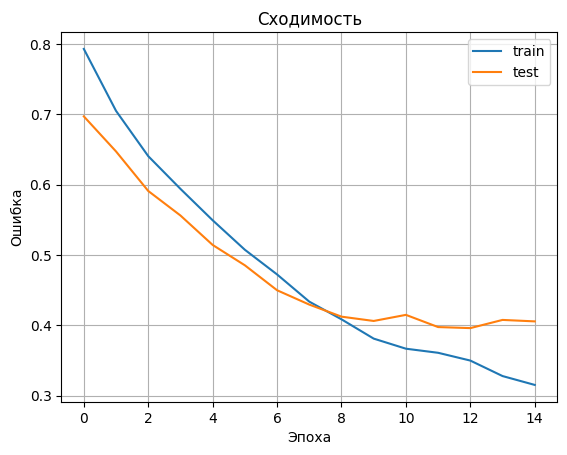

Model(
  (embedding): Embedding(116562, 5)
  (lstm): LSTM(5, 10, batch_first=True)
  (model): Sequential(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [472]:

converted_texts = [[converter[g] for g in i.split() if len(g) and g in converter] for i in texts]
mx = 50
fixed_texts = []
for i in converted_texts:
  bf = i[:]
  if len(bf) == 0:
    continue
  while len(bf) < mx:
    bf.append(0)
  while len(bf) > mx:
    bf.pop(-1)

  fixed_texts.append(np.array(bf))

#embed_texts = torch.Tensor([torch.tensor(i) for i in converted_texts if len(i)])
model = Model(len(vocab), 100, 50, 5)
y = []
for index, i in df.iterrows():
  ind = np.argmax([i['like'], i['funny'], i['wonder'], i['anger'], i['sadness']])
  bf = [0] * 5
  bf[ind] = 1
  y.append(float(i['sadness']))
  #y.append([i['like'], i['funny'], i['wonder'], i['anger'], i['sadness']])
  #y.append([i['like'], i['funny'], i['wonder'], i['anger'], i['sadness']])
y = torch.tensor(y)

print(y.shape)
#print(x.shape)
#y = [[i['like'], i['funny'], i['wonder'], i['anger'], i['sadness']] for i in df.items()]

train(model, torch.tensor(fixed_texts), y, 15)

In [473]:
def convert(text):
  res = [preprocess_text(i) for i in text.split()]
  res= [converter[g] for g in res if len(g) and g in converter]
  print(res)
  while len(res) < mx:
    res.append(0)
  while len(res) > mx:
    res.pop(-1)
  return res

txt = convert("выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл выиграл ")
#txt = fixed_texts[8]
print(txt)
model.eval()
result = model(torch.atleast_2d(torch.tensor(txt)))
print(result.detach().numpy())

txt = convert("погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб погиб ")
#txt = fixed_texts[8]
print(txt)
model.eval()
result = model(torch.atleast_2d(torch.tensor(txt)))
print(result.detach().numpy())

[20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419]
[20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 20419, 0, 0, 0]
[[0.0351129]]
[3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388, 3388